In [1]:
# %matplotlib widget

import os
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
from astropy.table import Table

from copy import deepcopy as copy
from tqdm import tqdm
import bottleneck as bn

from lvmdrp import path, __version__ as drpver
from lvmdrp.utils import metadata as md
from lvmdrp.functions import run_drp as drp
from lvmdrp.functions import run_quickdrp as qdrp

from lvmdrp.core.tracemask import TraceMask
from lvmdrp.functions import imageMethod
from lvmdrp.functions import rssMethod

ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")
MASTER_CON_LAMPS = {"b": "ldls", "r": "ldls", "z": "quartz"}
MASTER_ARC_LAMPS = {"b": "hgne", "r": "neon", "z": "neon"}
SLITMAP = Table(drp.fibermap.data)

In [2]:
MJD = 60206
drp.get_frames_metadata(mjd=MJD, overwrite=False)

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60206/raw_metadata.hdf5
[INFO]: Loading existing metadata store.
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60206/raw_metadata.hdf5


[INFO]: found 1035 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60206/raw_metadata.hdf5'
[INFO]: number of frames after filtering 1035
[INFO]: total number of frames found 1035


,hemi,tileid,mjd,rmjd,imagetyp,spec,camera,expnum,exptime,neon,...,xenon,argon,ldls,quartz,quality,qual,stage,status,drpqual,name
0,s,1111,60206,60206,object,sp2,r2,5223,300.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r2-00005223.fits
1,s,1111,60206,60206,object,sp2,b2,5214,300.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b2-00005214.fits
2,s,1111,60206,60206,flat,sp2,b2,5263,30.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b2-00005263.fits
3,s,1111,60206,60206,flat,sp1,b1,5237,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-b1-00005237.fits
4,s,1111,60206,60206,flat,sp2,z2,5255,300.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z2-00005255.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,s,1111,60206,60206,arc,sp2,r2,5250,150.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r2-00005250.fits
1031,s,1111,60206,60206,object,sp3,b3,5216,300.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b3-00005216.fits
1032,s,1111,60206,60206,flat,sp3,b3,5175,150.0,False,...,False,False,True,False,excellent,0,1,0,0,sdR-s-b3-00005175.fits
1033,s,1111,60206,60206,object,sp2,b2,5219,300.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b2-00005219.fits


In [3]:
flats_table = md.get_metadata(tileid="*", mjd=MJD, imagetyp="flat")
flats_table = flats_table.loc[flats_table.expnum.isin(range(5158, 5205+1))]
flats_table

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60206/raw_metadata.hdf5
[INFO]: found 1035 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60206/raw_metadata.hdf5'
[INFO]: filtering by imagetyp = 'flat'
[INFO]: number of frames after filtering 603
[INFO]: total number of frames found 603


,hemi,tileid,mjd,rmjd,imagetyp,spec,camera,expnum,exptime,neon,...,xenon,argon,ldls,quartz,quality,qual,stage,status,drpqual,name
3,s,1111,60206,60206,flat,sp1,b1,5164,150.0,False,...,False,False,True,False,excellent,0,1,0,0,sdR-s-b1-00005164.fits
4,s,1111,60206,60206,flat,sp3,z3,5201,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-z3-00005201.fits
6,s,1111,60206,60206,flat,sp2,r2,5196,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-r2-00005196.fits
7,s,1111,60206,60206,flat,sp3,r3,5160,150.0,False,...,False,False,True,False,excellent,0,1,0,0,sdR-s-r3-00005160.fits
8,s,1111,60206,60206,flat,sp3,z3,5185,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-z3-00005185.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,s,1111,60206,60206,flat,sp1,z1,5197,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-z1-00005197.fits
598,s,1111,60206,60206,flat,sp1,b1,5175,150.0,False,...,False,False,True,False,excellent,0,1,0,0,sdR-s-b1-00005175.fits
600,s,1111,60206,60206,flat,sp1,z1,5190,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-z1-00005190.fits
601,s,1111,60206,60206,flat,sp3,b3,5175,150.0,False,...,False,False,True,False,excellent,0,1,0,0,sdR-s-b3-00005175.fits


In [4]:
masters_mjd = qdrp.get_master_mjd(MJD)
masters_path = os.path.join(ORIG_MASTER_DIR, f"{masters_mjd}")
print(f"Using master calibrations from {masters_path}")

Using master calibrations from /home/mejia/Research/lvm/lvmdata/calib/60177


In [5]:
flat_analogs = flats_table.groupby(["camera"])

pri_ldls_expnums = np.arange(5158, 5169+1)
sec_ldls_expnums = np.arange(5170, 5181+1)
pri_qrtz_expnums, sec_qrtz_expnums = np.split(np.arange(5182, 5205+1), 2)

In [6]:
for camera in flat_analogs.groups:
    
    con_lamp = MASTER_CON_LAMPS[camera[0]]
    arc_lamp = MASTER_ARC_LAMPS[camera[0]]

    mtrace_path = os.path.join(masters_path, f"lvm-mtrace-{camera}.fits")
    mwidth_path = os.path.join(masters_path, f"lvm-mwidth-{camera}.fits")
    mwave_path = os.path.join(masters_path, f"lvm-mwave_{arc_lamp}-{camera}.fits")
    mlsf_path = os.path.join(masters_path, f"lvm-mlsf_{arc_lamp}-{camera}.fits")
    # define master fiberflat path
    mflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"mflat_{con_lamp}", camera=camera)
    wflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"wmflat_{con_lamp}", camera=camera)

    if os.path.isfile(wflat_path):
        print(f"skipping {wflat_path}, file already exist")
        continue

    # extract fiberflats
    imageMethod.extract_spectra(in_image=mflat_path, out_rss=wflat_path, in_trace=mtrace_path, in_fwhm=mwidth_path, method="optimal", parallel=4)

    # apply correction factor for the std fibers
    fibermap = SLITMAP[SLITMAP["spectrographid"] == int(camera[1])]
    select = fibermap["telescope"] == "Spec"
    flat = rssMethod.loadRSS(wflat_path)
    flat._data[select] = flat._data[select] * 24
    flat._error[select] = flat._error[select] * 24
    flat.writeFitsData(wflat_path)

    rssMethod.create_pixel_table(in_rss=wflat_path, out_rss=wflat_path, arc_wave=mwave_path, arc_fwhm=mlsf_path)

skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60206/calib/lvm-wmflat_ldls-b1.fits, file already exist
skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60206/calib/lvm-wmflat_ldls-b2.fits, file already exist
skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60206/calib/lvm-wmflat_ldls-b3.fits, file already exist
skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60206/calib/lvm-wmflat_ldls-r1.fits, file already exist
skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60206/calib/lvm-wmflat_ldls-r2.fits, file already exist
skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60206/calib/lvm-wmflat_ldls-r3.fits, file already exist
skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60206/calib/lvm-wmflat_quartz-z1.fits, fi

[INFO]: reading continuum exposure from lvm-wmflat_ldls-b1.fits
[INFO]: reading continuum exposure from lvm-wmflat_ldls-b2.fits
[INFO]: reading continuum exposure from lvm-wmflat_ldls-b3.fits
[INFO]: applying median smoothing with box size [1, 200] angstroms ([1, 337] pixels)
[INFO]: caculating normalization in full wavelength range (3504.81 - 5990.90 angstroms)
[INFO]: computing fiberflat across 1944 fibers and 4085 wavelength bins
[INFO]: applying gaussian smoothing with kernel size 100 angstroms (168 pixels)
[INFO]: creating diagnostic plots for fiberflat


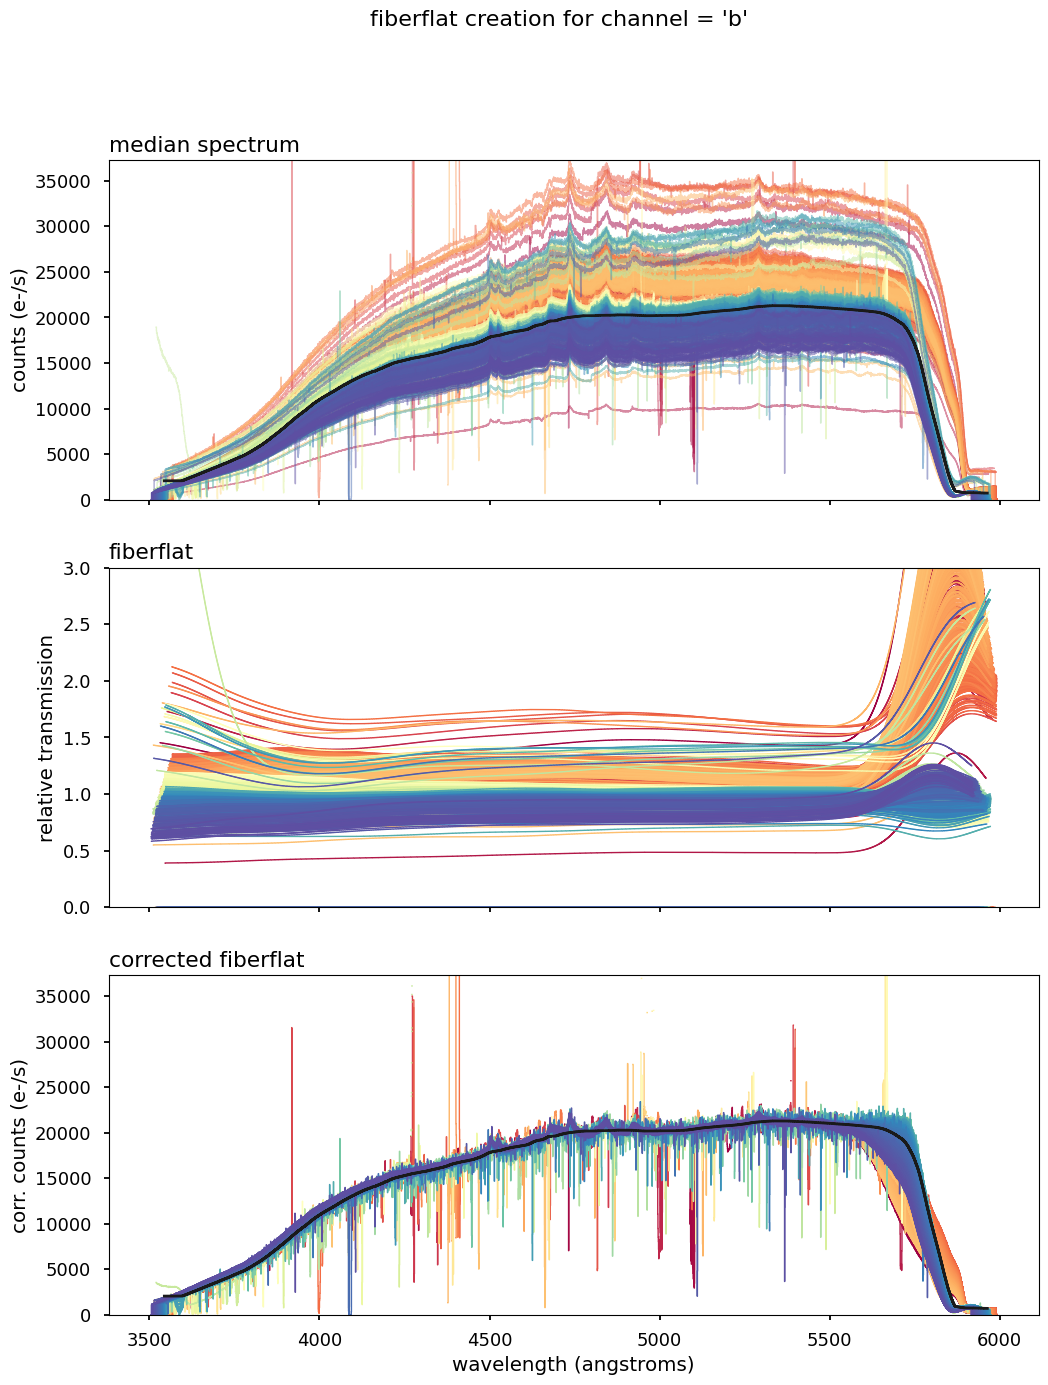

[INFO]: writing fiberflat to lvm-mfiberflat-b1.fits
[INFO]: fiberflat statistics: min = 0.391, max = 6.208, mean = 1.31, median = 1.20, std = 0.401
[INFO]: writing fiberflat to lvm-mfiberflat-b2.fits
[INFO]: fiberflat statistics: min = 0.551, max = 5.354, mean = 0.99, median = 0.98, std = 0.102
[INFO]: writing fiberflat to lvm-mfiberflat-b3.fits
[INFO]: fiberflat statistics: min = 0.584, max = 2.806, mean = 0.95, median = 0.95, std = 0.095
[INFO]: reading continuum exposure from lvm-wmflat_ldls-r1.fits
[INFO]: reading continuum exposure from lvm-wmflat_ldls-r2.fits
[INFO]: reading continuum exposure from lvm-wmflat_ldls-r3.fits
[INFO]: applying median smoothing with box size [1, 200] angstroms ([1, 378] pixels)
[INFO]: caculating normalization in full wavelength range (5560.01 - 7790.14 angstroms)
[INFO]: computing fiberflat across 1944 fibers and 4085 wavelength bins
[INFO]: applying gaussian smoothing with kernel size 100 angstroms (189 pixels)
[INFO]: creating diagnostic plots for f

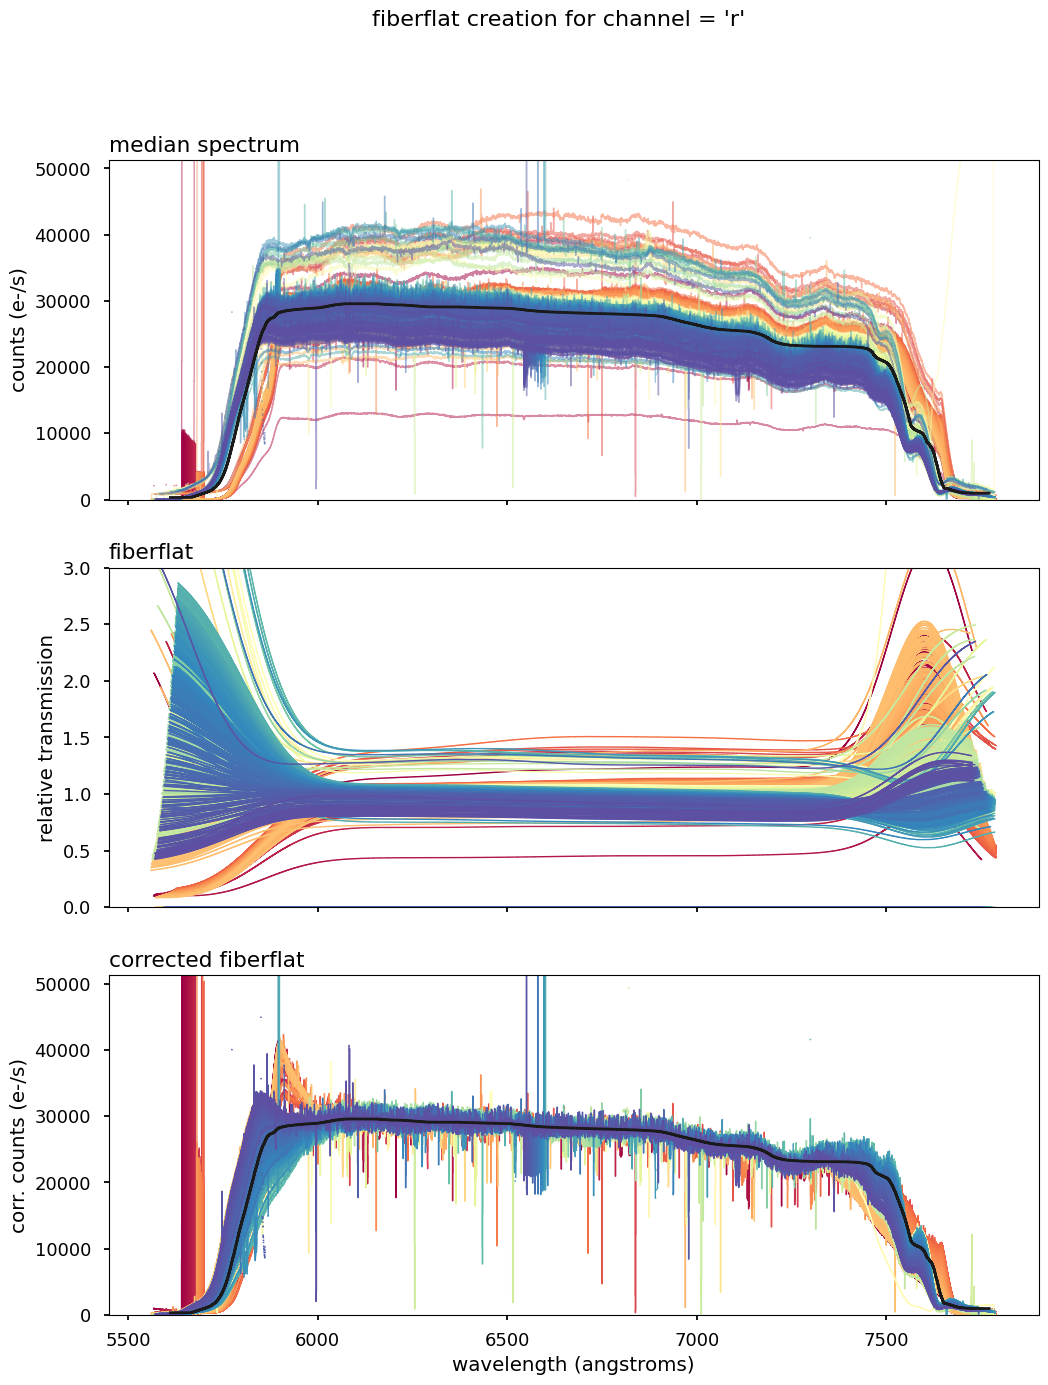

[INFO]: writing fiberflat to lvm-mfiberflat-r1.fits
[INFO]: fiberflat statistics: min = 0.085, max = 3.311, mean = 0.97, median = 1.01, std = 0.319
[INFO]: writing fiberflat to lvm-mfiberflat-r2.fits
[INFO]: fiberflat statistics: min = 0.327, max = 57.475, mean = 1.04, median = 1.01, std = 0.499
[INFO]: writing fiberflat to lvm-mfiberflat-r3.fits
[INFO]: fiberflat statistics: min = 0.425, max = 6.660, mean = 1.04, median = 0.98, std = 0.295
[INFO]: reading continuum exposure from lvm-wmflat_quartz-z1.fits
[INFO]: reading continuum exposure from lvm-wmflat_quartz-z2.fits
[INFO]: reading continuum exposure from lvm-wmflat_quartz-z3.fits
[INFO]: applying median smoothing with box size [1, 200] angstroms ([1, 333] pixels)
[INFO]: caculating normalization in full wavelength range (7343.97 - 9889.75 angstroms)
[INFO]: computing fiberflat across 1944 fibers and 4085 wavelength bins
[INFO]: applying gaussian smoothing with kernel size 100 angstroms (166 pixels)
[INFO]: creating diagnostic plot

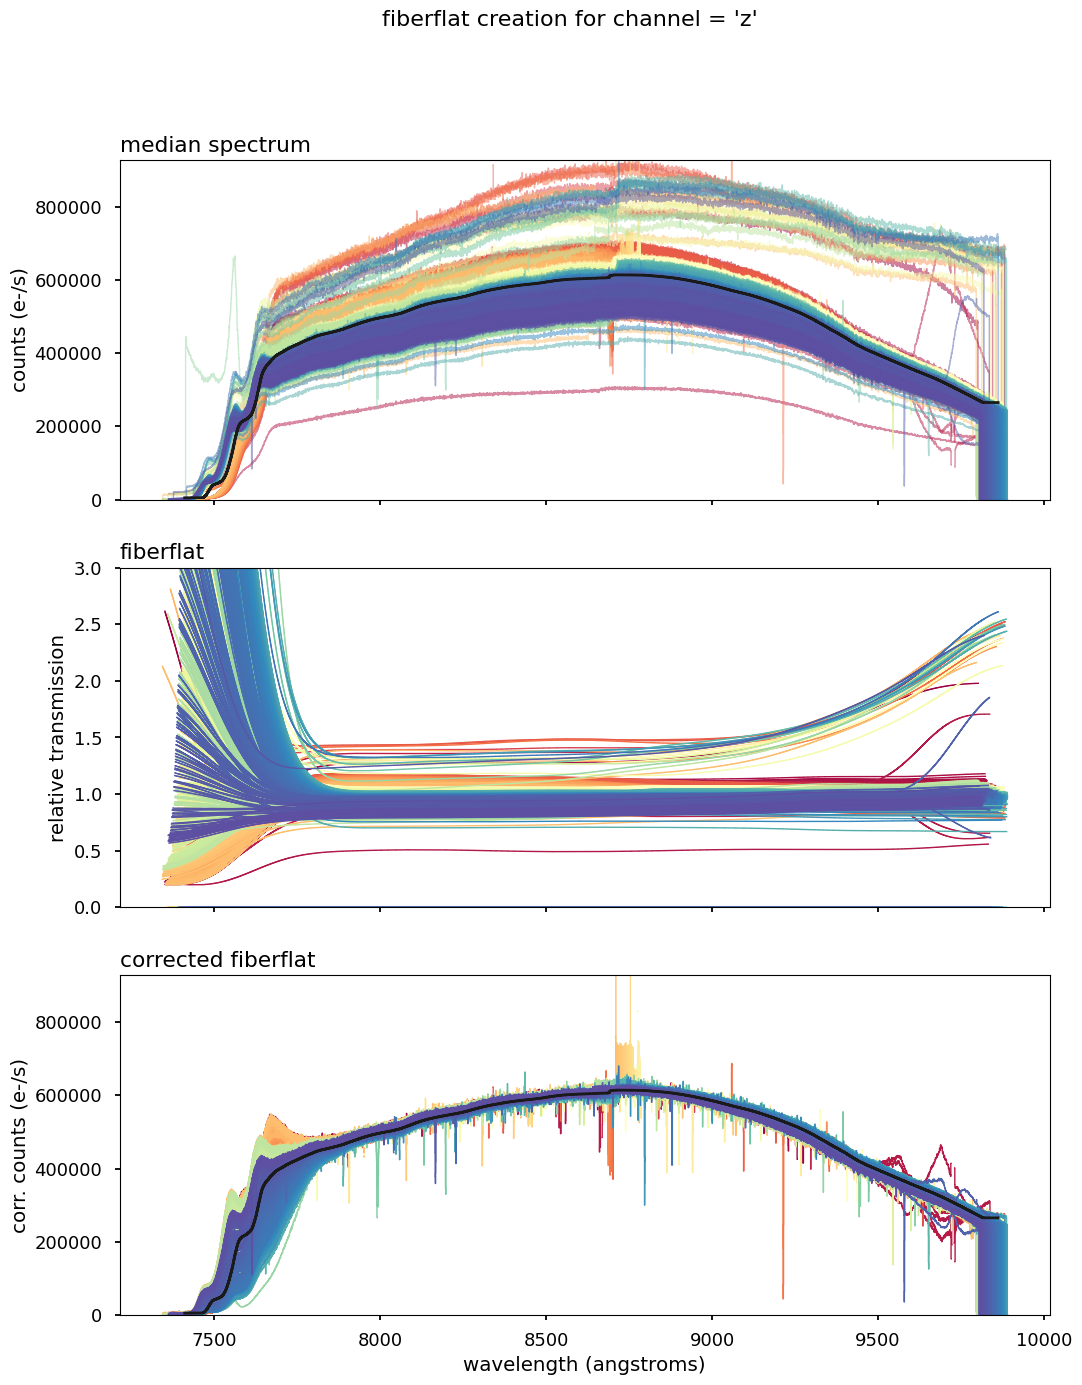

[INFO]: writing fiberflat to lvm-mfiberflat-z1.fits
[INFO]: fiberflat statistics: min = 0.198, max = 4.307, mean = 1.00, median = 1.04, std = 0.177
[INFO]: writing fiberflat to lvm-mfiberflat-z2.fits
[INFO]: fiberflat statistics: min = 0.248, max = 9.640, mean = 1.06, median = 1.01, std = 0.394
[INFO]: writing fiberflat to lvm-mfiberflat-z3.fits
[INFO]: fiberflat statistics: min = 0.568, max = 49.678, mean = 1.22, median = 0.98, std = 1.083


In [15]:
from importlib import reload

reload(rssMethod)

wave_ranges = {"b": [0, 5850], "r": (5800, 7500), "z": (7550, 1e12)}
for channel in "brz":
    wflat_paths = []
    mfiberflat_paths = []

    for specid in (1,2,3):
        camera = f"{channel}{specid}"
        con_lamp = MASTER_CON_LAMPS[camera[0]]
        wflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"wmflat_{con_lamp}", camera=camera)
        mfiberflat_path = os.path.join(masters_path, f"lvm-mfiberflat-{camera}.fits")
        wflat_paths.append(wflat_path)
        mfiberflat_paths.append(mfiberflat_path)
    rssMethod.create_fiberflat(in_rsss=wflat_paths, out_rsss=mfiberflat_paths, median_box=200, gaussian_kernel=100, display_plots=True)